# CAPSTONE PROJECT 2: A COMPUTER VISION MODEL WHICH DETECTS BONE FRACTURES IN THE UPPER EXTREMITIES NAMELY: WRISTS, FOREARMS, UPPER ARM, & SHOULDER FRACTURES
#### DATA WRANGLING

In [2]:
# import necessary modules for Data Wrangling, namely Pandas, numpy, & motplotlib.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import extra modules as needed here:
import yaml
import os
import torch
from torch import nn
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random

In [7]:
# set up cuda environment
torch.cuda.empty_cache()

BS = 16
LR = 0.00005
epochs = 20
IS = 256
D = 'cuda' if torch.cuda.is_available() else 'cpu'

# set up global variables
num_classes = 7
classes = ['elbow positive', 'fingers positive', 'forearm fracture', 'humerus fracture', 'humerus', 'shoulder fracture', 'wrist positive']
c2l = {k:v for k,v in list(zip(classes,list(range(num_classes))))}
l2c = {v:k for k,v in c2l.items()}

# Project Main Directory path
dir_path = r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2"

# Train Data Paths
train_dir_path = r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\train"
train_img_paths = sorted(os.listdir(r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\train\images"))
train_target_paths = sorted(os.listdir(r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\train\labels"))

# Valid Data Paths
val_dir_path = r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\valid"
val_img_paths = sorted(os.listdir(r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\valid\images"))
val_target_paths = sorted(os.listdir(r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\valid\labels"))

# Test Data Paths
test_dir_path = r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\test"
test_img_paths = sorted(os.listdir(r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\test\images"))
test_target_paths = sorted(os.listdir(r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\test\labels"))

Verify that image data can be accessed and presented.

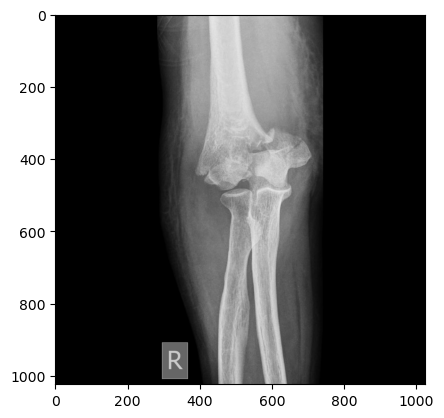

In [10]:
ip=os.path.join(train_dir_path, 'images', train_img_paths[0])
image=cv2.imread(ip)

plt.imshow(image)
plt.show()

In [14]:
# Define Local Classes and functions for this project
def unconvert(width, height, x, y, w, h):

    xmax = int((x*width) + (w * width)/2.0)
    xmin = int((x*width) - (w * width)/2.0)
    ymax = int((y*height) + (h * height)/2.0)
    ymin = int((y*height) - (h * height)/2.0)

    return xmin, ymin, xmax, ymax

augs=A.Compose([
    A.Resize(IS,IS),
],bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']), is_check_shapes=True)

class FractureData(torch.utils.data.Dataset):
    
    def __init__(self, dir_path, img_paths, target_paths, augs=None):
        self.dir_path=dir_path
        self.img_paths=img_paths
        self.target_paths=target_paths
        self.augs=augs
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self,idx):
        ip=os.path.join(self.dir_path,'images',self.img_paths[idx])
        tp=os.path.join(self.dir_path,'labels',self.target_paths[idx])
        
        image=cv2.imread(ip)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        H,W,_=image.shape
        
        file=open(tp,'r')
        target=list(map(float,file.read().split()))
        
        try:
            label=[target.pop(0)]
            bbox=[]    
            i=0
            while i<len(target):
                x,y,w,h=target[i:i+4]
                bbox.append([*unconvert(W,H,x,y,w,h)])
                i+=4
            label=label*len(bbox)
        
            if self.augs!=None:
                data=self.augs(image=image,bboxes=bbox,class_labels=['None']*len(label))
                image=data['image']
                bbox=data['bboxes']
        except:
            if idx+1<len(self.img_paths):
                return self.__getitem__(idx+1)
            else:
                return self.__getitem__(0)
            
        image=torch.Tensor(np.transpose(image,(2,0,1)))/255.0
        bbox=torch.Tensor(bbox).long()
        label=torch.Tensor(label).long()
        
        annot={'boxes':bbox,'labels':label}
        
        return image, annot
    
    def collate_fn(self,batch):
        return tuple(zip(*batch))

Store image and target paths into a data Frame with their respective appendage classification.

In [15]:
df_train = pd.DataFrame({'images': train_img_paths, 'labels': train_target_paths, 'classes': np.NaN, 'class-num': np.NaN})

In [16]:
df_train

,images,labels,classes,class-num
0,distal-humeral-fractures-2-_JPEG.rf.39ba3f5304...,distal-humeral-fractures-2-_JPEG.rf.39ba3f5304...,NaN,NaN
1,distal-humeral-fractures-2-_JPEG.rf.525ce87678...,distal-humeral-fractures-2-_JPEG.rf.525ce87678...,NaN,NaN
2,distal-humeral-fractures-2-_JPEG.rf.f9442db05e...,distal-humeral-fractures-2-_JPEG.rf.f9442db05e...,NaN,NaN
3,elbow-dislocation-with-coronoid-process-fractu...,elbow-dislocation-with-coronoid-process-fractu...,NaN,NaN
4,elbow-dislocation-with-coronoid-process-fractu...,elbow-dislocation-with-coronoid-process-fractu...,NaN,NaN
...,...,...,...,...
3626,image3_633_png.rf.5d680e5b7b274193bab074c5f7c6...,image3_633_png.rf.5d680e5b7b274193bab074c5f7c6...,NaN,NaN
3627,image3_633_png.rf.c270592f9233a3b020aeeeb3be9e...,image3_633_png.rf.c270592f9233a3b020aeeeb3be9e...,NaN,NaN
3628,image3_739_png.rf.18f786497037df161b4687b00112...,image3_739_png.rf.18f786497037df161b4687b00112...,NaN,NaN
3629,image3_739_png.rf.5497c3cd199cb2d1da07d1d1cb63...,image3_739_png.rf.5497c3cd199cb2d1da07d1d1cb63...,NaN,NaN


In [20]:
trainset=FractureData(train_dir_path, train_img_paths, train_target_paths, augs)
trainloader=torch.utils.data.DataLoader(trainset,batch_size=BS,collate_fn=trainset.collate_fn)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


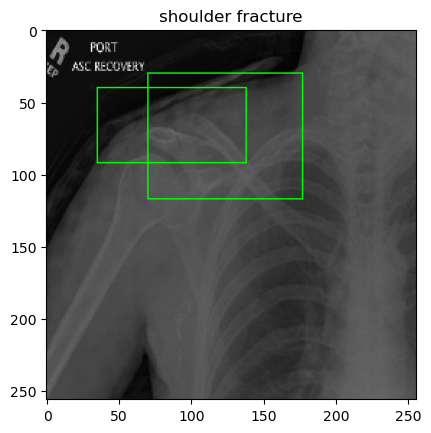

In [24]:
for image,target in trainloader:
    break
img, tar = image[10].permute(1,2,0).numpy(), target[10]

for bbox in tar['boxes']:
    xmin,ymin,xmax,ymax=bbox[0].item(), bbox[1].item(), bbox[2].item(), bbox[3].item()
    sp,ep=(xmin,ymin),(xmax,ymax)
    cv2.rectangle(img,sp,ep,(0,255,0),1)

plt.imshow(img)
plt.title(l2c[tar['labels'][0].item()])
plt.show()

In [25]:
len(image)

16